[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zohar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zohar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zohar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zohar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\zohar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.42
Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       118
        fear       0.36      0.13      0.19        99
         joy       0.43      0.88      0.58        96
        love       0.85      0.41      0.55       101
     sadness       0.27      0.81      0.41        91
    surprise       1.00      0.42      0.59        95

    accuracy                           0.42       600
   macro avg       0.49      0.44      0.39       600
weighted avg       0.47      0.42      0.37       600



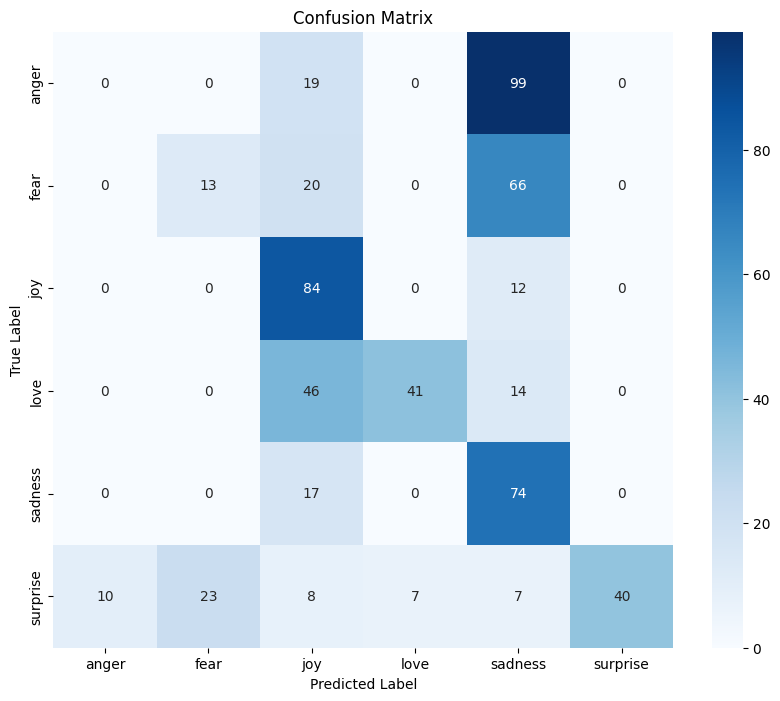

AttributeError: 'tuple' object has no attribute 'predict_proba'

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from imblearn.over_sampling import SMOTE
from collections import Counter
from textblob import TextBlob
import joblib

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Load stopwords and initialize lemmatizer and sentiment analyzer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

# Advanced text preprocessing
def preprocess_text(text):
    # Convert to lowercase and remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

# Custom transformer for SMOTE
class SMOTETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.smote = SMOTE(random_state=self.random_state)

    def fit(self, X, y):
        return self

    def transform(self, X, y=None):
        if y is not None:
            X_resampled, y_resampled = self.smote.fit_resample(X, y)
            return X_resampled
        return X

# Custom feature extractors
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([len(text.split()) for text in X]).reshape(-1, 1)

class ExclamationCountExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([text.count('!') for text in X]).reshape(-1, 1)

class UppercaseRatioExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0 for text in X]).reshape(-1, 1)

class SentimentScoreExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([sia.polarity_scores(text)['compound'] for text in X]).reshape(-1, 1)

class TextBlobFeaturesExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for text in X:
            blob = TextBlob(text)
            features.append([
                blob.sentiment.polarity,
                blob.sentiment.subjectivity,
            ])
        return np.array(features)

# Load dataset
df = pd.read_csv('../sampled_data.csv', header=None, names=['text', 'label'], delimiter=',', quoting=3)

# Preprocess text
df['processed_text'] = df['text'].apply(preprocess_text)

# Encode labels
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

# Split data into features and labels
X = df['processed_text']
y = df['encoded_label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with feature union
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('count', CountVectorizer(ngram_range=(1, 3), max_features=1000)),
        ('text_length', TextLengthExtractor()),
        ('exclamation_count', ExclamationCountExtractor()),
        ('uppercase_ratio', UppercaseRatioExtractor()),
        ('sentiment_score', SentimentScoreExtractor()),
        ('textblob_features', TextBlobFeaturesExtractor())
    ])),
    ('smote', SMOTETransformer(random_state=42)),
    ('clf', AdaBoostClassifier( random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'features__count__max_features': [5000, 10000],
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.1, 1.0]
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Get best model
model = grid_search.best_estimator_

# Save the model to a .pkl file
file_name = '../trained_models/AB_CV.pkl'
joblib.dump((CountVectorizer(ngram_range=(1, 3), max_features=1000),model), file_name)

# Load the model from a .pkl file
vectorizer, classifier = joblib.load(file_name)
# loaded_model = joblib.load(file_name)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC AUC Score
y_pred_proba = loaded_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"ROC AUC Score: {roc_auc}")

# Cross-validation score
cv_scores = cross_val_score(loaded_model, X, y, cv=5, scoring='f1_macro')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {np.mean(cv_scores)}")

# Feature importance (for CountVectorizer features only)
count_transformer = loaded_model.named_steps['features'].transformer_list[0][1]
count_features = count_transformer.get_feature_names_out()
feature_importance = loaded_model.named_steps['clf'].feature_importances_[:len(count_features)]
sorted_idx = np.argsort(feature_importance)
top_20_features = sorted_idx[-20:]


# Learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    loaded_model, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('F1 score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

# Class distribution
class_dist = Counter(y)
plt.figure(figsize=(10, 6))
plt.bar(le.classes_, [class_dist[i] for i in range(len(le.classes_))])
plt.title('Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Test the model with new examples
new_examples = [
    "I am so excited about the upcoming vacation!",
    "I feel completely overwhelmed with work right now.",
    "The kids are really making me angry today."
]

# Predict emotions for the new examples
predictions = loaded_model.predict(new_examples)
probabilities = loaded_model.predict_proba(new_examples)

# Output predictions
for example, prediction, proba in zip(new_examples, predictions, probabilities):
    print(f"Text: {example}")
    print(f"Predicted Emotion: {le.inverse_transform([prediction])[0]}")
    print("Probabilities:")
    for emotion, prob in zip(le.classes_, proba):
        print(f"  {emotion}: {prob:.2f}")
    print()
